# Blood Donation

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from pylab import rcParams      
rcParams['figure.figsize'] = 8, 8
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, roc_curve, auc
from sklearn.cross_validation import train_test_split

/Users/dmitrys/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [4]:
def plot_roc_curve(predictions):
    preds = predictions[:,1]
    fpr, tpr, threshold = roc_curve(yval, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("BloodDonationSubmissionFormat.csv")

In [6]:
train.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


In [7]:
test.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
0,659,2,12,3000,52
1,276,21,7,1750,38
2,263,4,1,250,4
3,303,11,11,2750,38
4,83,4,12,3000,34


In [8]:
train["Test"] = False
test["Test"] = True
data = pd.concat([train, test], ignore_index=True)

In [9]:
data.describe()

,Made Donation in March 2007,Months since First Donation,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Unnamed: 0
count,576.000000,776.000000,776.000000,776.000000,776.000000,776.000000
mean,0.239583,34.417526,9.453608,5.557990,1389.497423,374.171392
std,0.427200,24.450047,8.030935,5.841939,1460.484632,215.330133
min,0.000000,2.000000,0.000000,1.000000,250.000000,0.000000
25%,0.000000,16.000000,3.000000,2.000000,500.000000,187.750000
50%,0.000000,28.000000,7.000000,4.000000,1000.000000,375.500000
75%,0.000000,50.000000,14.000000,7.000000,1750.000000,558.250000
max,1.000000,98.000000,74.000000,50.000000,12500.000000,747.000000


In [10]:
data.shape

(776, 7)

In [11]:
def make_submission(predictions):
    to_submit = pd.DataFrame(predictions, index=indecies, columns=["Made Donation in March 2007"])
    return to_submit

In [12]:
def plot_confusion(predictions, title):
    import seaborn as sns
    array = confusion_matrix(yval, predictions)
    df_cm = pd.DataFrame(array)
    plt.figure(figsize = (3,3))
    sns.heatmap(df_cm, annot=True, fmt='g', cbar=False)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title(title);

In [13]:
def plot_correlations(data, size=(5,5)):
    data = data.drop(["Unnamed: 0", "Made Donation in March 2007", "Test"], axis=1)
    columns = data.columns
    data = data.T
    data = pd.DataFrame(np.corrcoef(data), columns=columns, index=columns)
    plt.figure(figsize=size)
    sns.heatmap(data, annot=True, fmt='g', cbar=False)
    plt.xticks(rotation=45)

In [14]:
def importance(model):
    
    ### возвращает отсортированные по абсолютному значению коэффициенты
    
    coefs = pd.DataFrame(model.coef_.T, index=Xtr.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

In [15]:
def visualize_coefficients(classifier, feature_names, n_top_features=10):
    
    ### визулизирует влияние факторов на целевую переменную
    
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

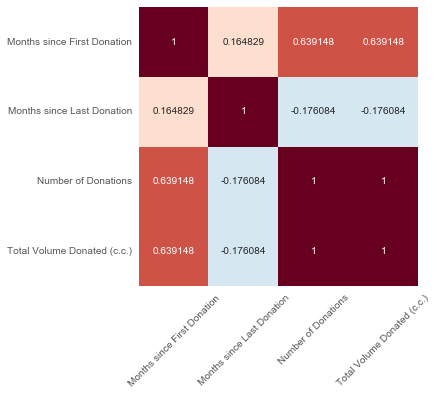

In [16]:
plot_correlations(data)

In [17]:
log_data = (data.drop(["Unnamed: 0", "Made Donation in March 2007", "Test"], axis=1)+1).apply(np.log)
log_data.columns = log_data.columns.map(lambda x: "log "+x)

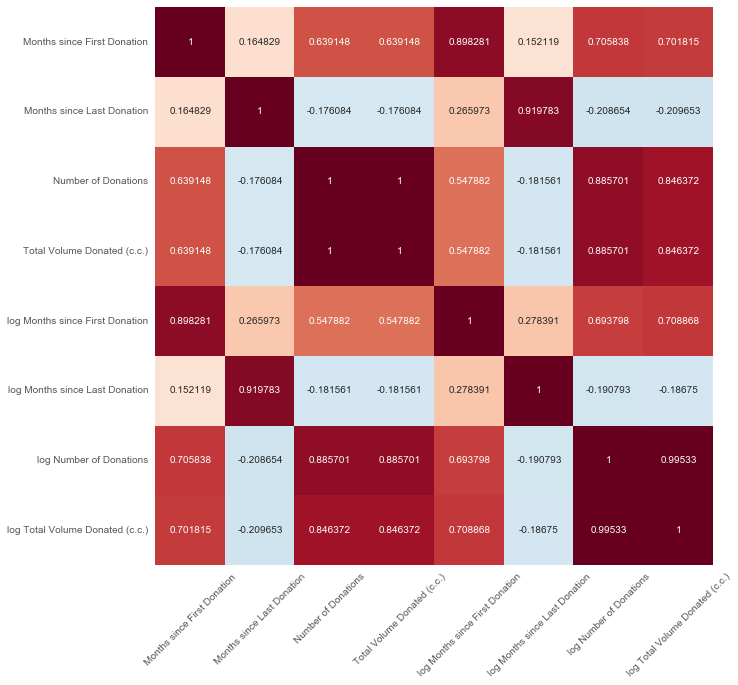

In [18]:
plot_correlations(pd.concat([data, log_data], axis=1), size=(10, 10))

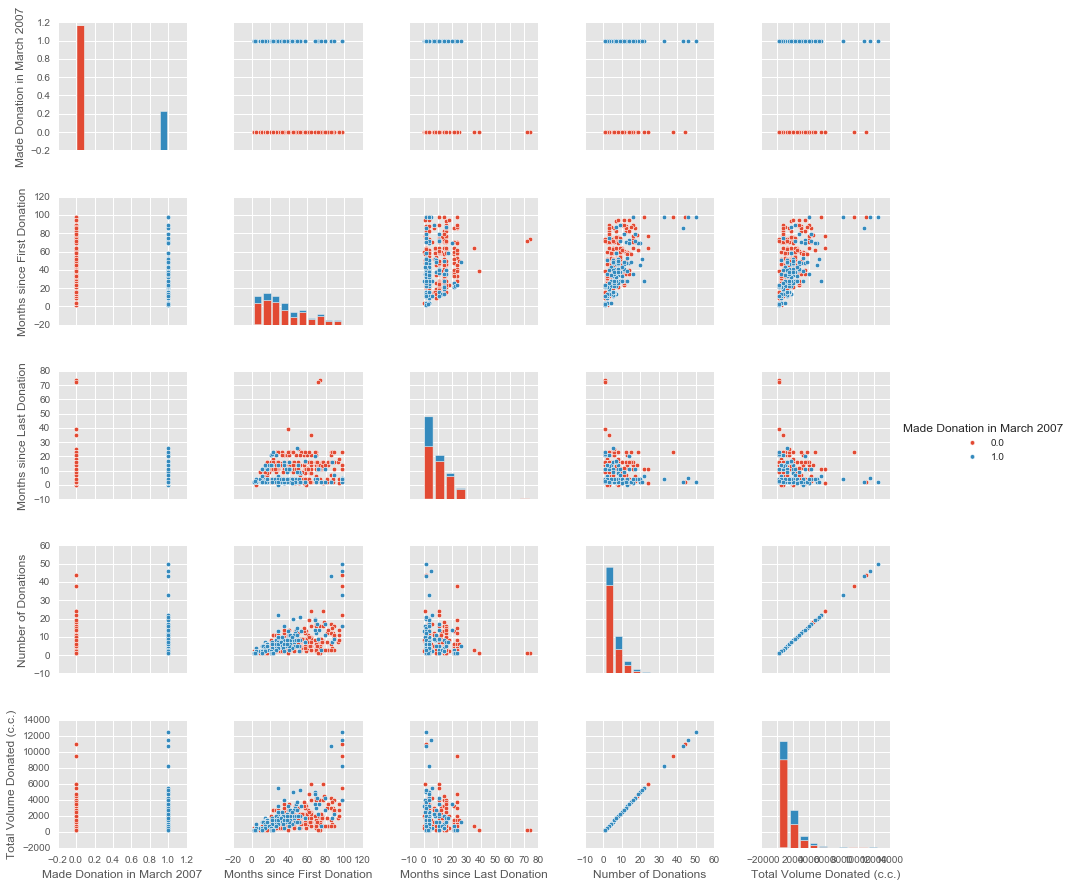

In [20]:
cols = data.drop(["Test","Unnamed: 0"], axis=1).columns
sns_plot = sns.pairplot(data[~data.Test][cols], hue='Made Donation in March 2007')

In [34]:
%%time
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[~X.Test])
tsne = TSNE(n_components=2)
tsne_representation = tsne.fit_transform(X_scaled)

CPU times: user 2.61 s, sys: 190 ms, total: 2.8 s
Wall time: 3.29 s


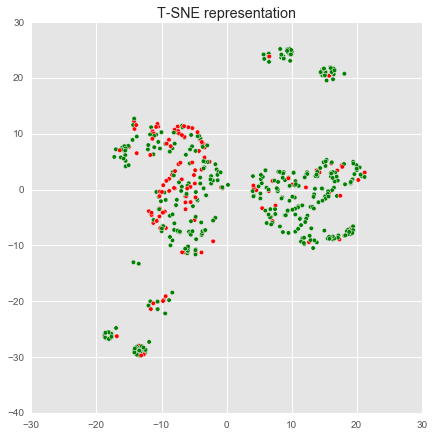

In [35]:
plt.figure(figsize=(7,7))
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=y.map({0: 'green', 1: 'red'}))
plt.title("T-SNE representation");

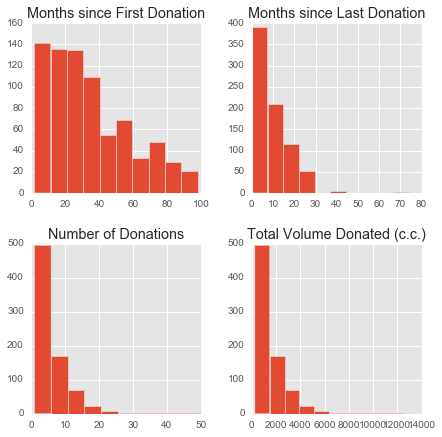

In [23]:
(data.drop(["Unnamed: 0", "Made Donation in March 2007", "Test"], axis=1)).hist(figsize=(7, 7));

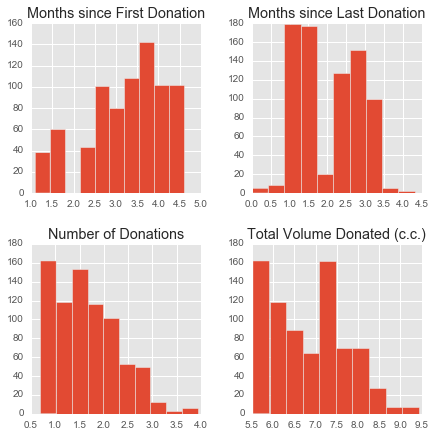

In [24]:
(data.drop(["Unnamed: 0", "Made Donation in March 2007", "Test"], axis=1)+1).apply(np.log).hist(figsize=(7, 7));

In [25]:
pd.qcut(log_data.ix[0], 10)

log Months since First Donation     (4.462, 5.079]
log Months since Last Donation     [1.0986, 1.949]
log Number of Donations            (3.649, 4.0645]
log Total Volume Donated (c.c.)     (7.982, 9.434]
Name: 0, dtype: category
Categories (10, object): [[1.0986, 1.949] < (1.949, 2.799] < (2.799, 3.649] < (3.649, 4.0645] ... (4.462, 5.079] < (5.079, 6.53] < (6.53, 7.982] < (7.982, 9.434]]

In [46]:
data["months_between_fst_lst"] = data["Months since First Donation"] - data["Months since Last Donation"]

In [ ]:
data.

In [26]:
y = train['Made Donation in March 2007']
train.drop(['Made Donation in March 2007', 'Unnamed: 0'], axis = 1, inplace=True)
indecies = list(test["Unnamed: 0"])
test.drop(['Unnamed: 0'], axis = 1, inplace=True)

In [27]:
X = pd.concat([data, log_data], axis=1).drop(['Made Donation in March 2007', 'Unnamed: 0'], axis = 1)
#(train+1).apply(np.log)

In [28]:
Xtr, Xval, ytr, yval = train_test_split(X[~X.Test], y, test_size=0.3, random_state=42)

In [29]:
Xtr.shape, Xval.shape

((403, 9), (173, 9))

In [36]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, n_jobs=3)
rf.fit(Xtr, ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=3, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [37]:
print(log_loss(yval, rf.predict_proba(Xval)))
print(roc_auc_score(yval, rf.predict_proba(Xval)[:,1]))

0.814459777501
0.701612903226


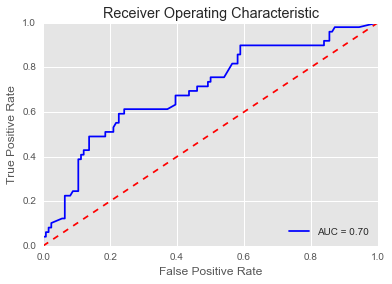

In [38]:
plot_roc_curve(rf.predict_proba(Xval))

In [26]:
from sklearn.calibration import CalibratedClassifierCV
calib = CalibratedClassifierCV(RandomForestClassifier(n_jobs=3, n_estimators=1000), cv=10, method='isotonic')
calib.fit(Xtr, ytr)


CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=3, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
            cv=10, method='isotonic')

In [27]:
print(log_loss(yval, calib.predict_proba(Xval)))
print(roc_auc_score(yval, calib.predict(Xval)))

0.571117572289
0.604674127716


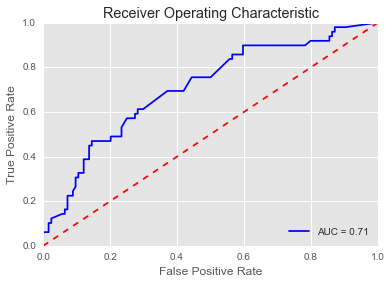

In [29]:
plot_roc_curve(calib.predict_proba(Xval))

In [162]:
import sys
sys.path.append('/Users/dmitrys//xgboost/python-package/')
import xgboost as xgb

In [168]:
dtrain = xgb.DMatrix(X[~X.Test], label=y)

In [197]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'eta': 0.01,
    'subsample': 0.5,
    'min_child_weight': 1,
    'colsample_bytree':0.6
}
trees = 500

In [198]:
cv = xgb.cv(params, dtrain, metrics=('logloss'), verbose_eval=False, nfold=7, show_stdv=False, num_boost_round=trees)

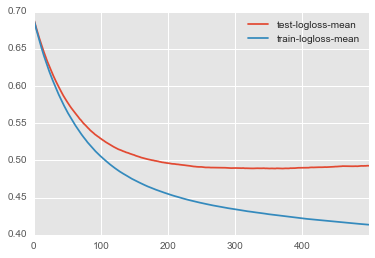

In [199]:
cv.plot(y=['test-logloss-mean', 'train-logloss-mean'])

In [200]:
cv.loc[cv['test-logloss-mean'].argmin()]

test-logloss-mean     0.489066
test-logloss-std      0.053792
train-logloss-mean    0.427674
train-logloss-std     0.007667
Name: 350, dtype: float64

In [201]:
cv['test-logloss-mean'].argmin()

350

In [202]:
bst = xgb.train(params, dtrain, num_boost_round=cv['test-logloss-mean'].argmin())

In [203]:
imps = pd.Series(bst.get_fscore()).sort_values()

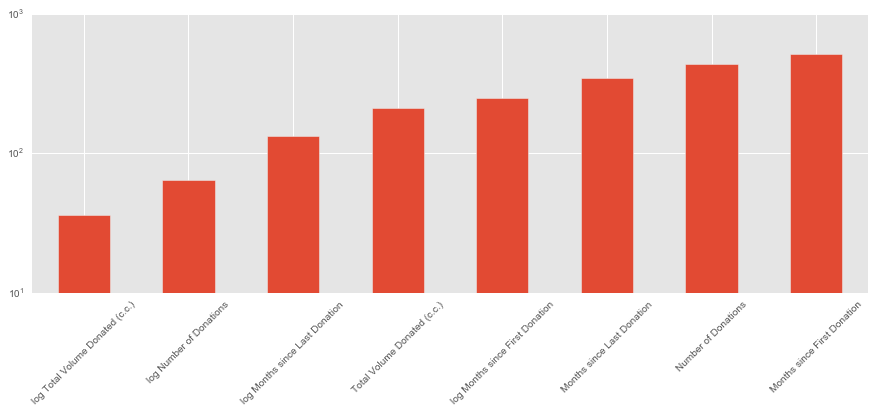

In [207]:
imps.plot(kind='bar', figsize=(15,5),logy=True)
plt.xticks(rotation=45);

             precision    recall  f1-score   support

          0       0.74      0.98      0.84       124
          1       0.70      0.14      0.24        49

avg / total       0.73      0.74      0.67       173

[[121   3]
 [ 42   7]]


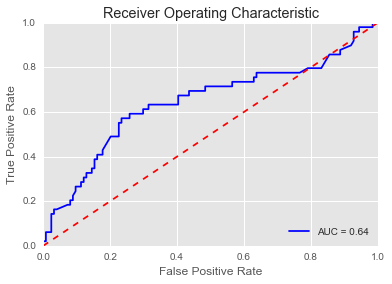

In [107]:
from sklearn import metrics
from sklearn.svm import SVC
# fit a SVM model to the data

model_SVM = SVC(probability=True)
model_SVM.fit(Xtr, ytr)
#print(model_SVM)
# make predictions
expected = yval
predicted = model_SVM.predict(Xval)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_roc_curve(model_SVM.predict_proba(Xval))

GaussianNB(priors=None)
             precision    recall  f1-score   support

          0       0.77      0.89      0.83       124
          1       0.55      0.35      0.42        49

avg / total       0.71      0.73      0.71       173

[[110  14]
 [ 32  17]]


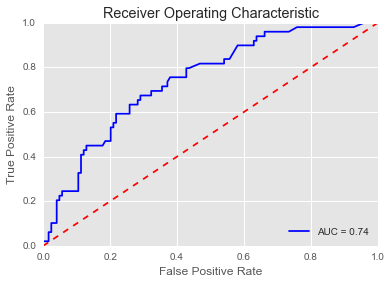

In [116]:
from sklearn.naive_bayes import GaussianNB
model_B = GaussianNB()
model_B.fit(Xtr, ytr)
print(model_B)
# make predictions
expected = yval
predicted = model_B.predict(Xval)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_roc_curve(model_B.predict_proba(Xval))

('Train logloss', 0.45700561728914363)
('Train roc_auc', 0.58117440778644536)
('Validation logloss', 0.50157992424500486)
('Validation roc_auc', 0.56953587886767609)


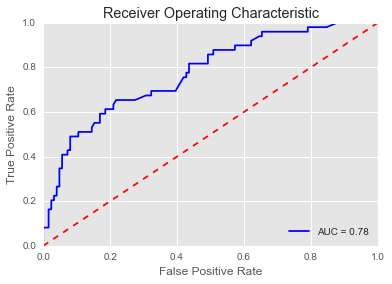

In [117]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(Xtr, ytr)

print('Train logloss', log_loss(ytr, lr.predict_proba(Xtr)))
print('Train roc_auc', roc_auc_score(ytr, lr.predict(Xtr)))
print('Validation logloss', log_loss(yval, lr.predict_proba(Xval)))
print('Validation roc_auc', roc_auc_score(yval, lr.predict(Xval)))
plot_roc_curve(lr.predict_proba(Xval))

In [146]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression())
pipeline.fit(Xtr, ytr)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

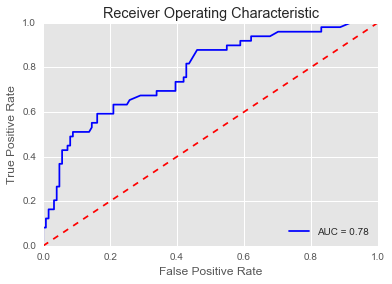

In [147]:
plot_roc_curve(pipeline.predict_proba(Xval))

In [152]:
importance(pipeline.named_steps["logisticregression"])

,coef
Months since First Donation,-0.879476
log Total Volume Donated (c.c.),0.552242
log Number of Donations,0.370227
Months since Last Donation,-0.281953
log Months since Last Donation,-0.140127
log Months since First Donation,0.118439
Number of Donations,0.085379
Total Volume Donated (c.c.),0.085379
Test,0.000000


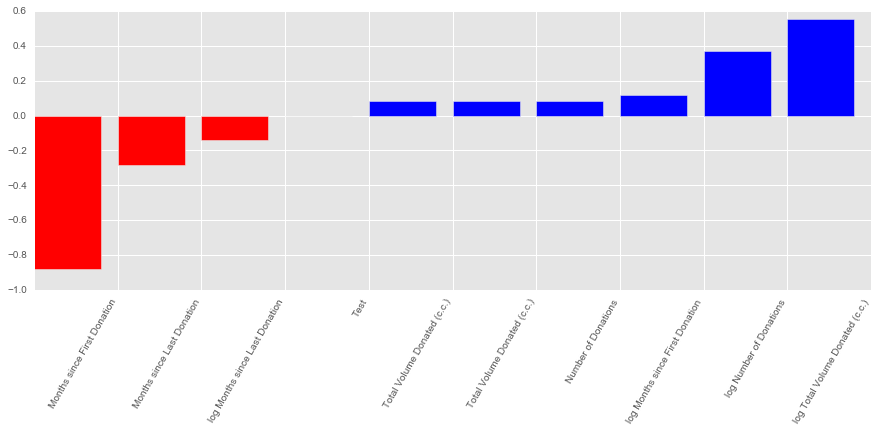

In [153]:
visualize_coefficients(pipeline.named_steps["logisticregression"], feature_names=Xtr.columns, n_top_features=5)

In [275]:
from sklearn.grid_search import GridSearchCV
Cs = 10**np.linspace(-5, 7, num=30)
grid = {'C': Cs}
gridsearch = GridSearchCV(LogisticRegression(), grid, scoring='neg_log_loss', cv=5)
%time gridsearch.fit(scaler.transform(X[~X.Test]), y)

CPU times: user 723 ms, sys: 5.8 ms, total: 729 ms
Wall time: 744 ms


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-05,   2.59294e-05,   6.72336e-05,   1.74333e-04,
         4.52035e-04,   1.17210e-03,   3.03920e-03,   7.88046e-03,
         2.04336e-02,   5.29832e-02,   1.37382e-01,   3.56225e-01,
         9.23671e-01,   2.39503e+00,   6.21017e+00,   1.61026e+01,
         4.1753...    8.53168e+04,   2.21222e+05,   5.73615e+05,   1.48735e+06,
         3.85662e+06,   1.00000e+07])},
       pre_dispatch='2*n_jobs', refit=True, scoring='neg_log_loss',
       verbose=0)

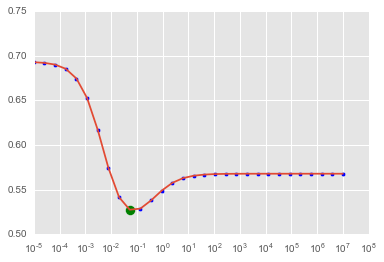

In [276]:
scores = [-x.mean_validation_score for x in  gridsearch.grid_scores_]
plt.plot(Cs, scores)
plt.scatter(Cs, scores)
plt.scatter(Cs[np.argmin(scores)], scores[np.argmin(scores)], c='g', s=100)
plt.xscale('log')

In [277]:
C = Cs[np.argmin(scores)]
C

0.052983169062837072

('Train logloss', 0.47023859633036291)
('Train roc_auc', 0.52658698919344449)
('Validation logloss', 0.50669645758161386)
('Validation roc_auc', 0.53061224489795922)


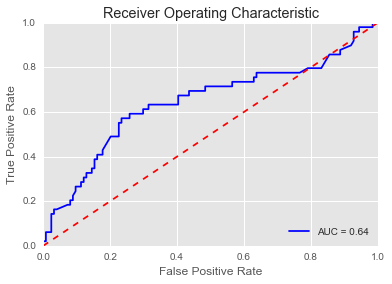

In [278]:
lr = LogisticRegression(C=C)
lr.fit(Xtr, ytr)
print('Train logloss', log_loss(ytr, lr.predict_proba(Xtr)))
print('Train roc_auc', roc_auc_score(ytr, lr.predict(Xtr)))
print('Validation logloss', log_loss(yval, lr.predict_proba(Xval)))
print('Validation roc_auc', roc_auc_score(yval, lr.predict(Xval)))
plot_roc_curve(model_SVM.predict_proba(Xval))

In [56]:
xgb_prediction = bst.predict(xgb.DMatrix(test))

In [131]:
Xtr.shape

(403, 9)

In [132]:
X.shape

(776, 9)

In [135]:
to_submit = make_submission(lr.predict_proba(X[X.Test])[:,1])

In [213]:
to_submit = make_submission(bst.predict(xgb.DMatrix(X[X.Test])))

In [216]:
to_submit.to_csv('/Users/dmitrys/Desktop/DataProjects/DrivenData/BloodDonations/submission.csv')

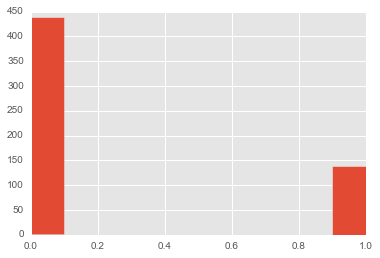

In [214]:
y.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1215e4950>]], dtype=object)

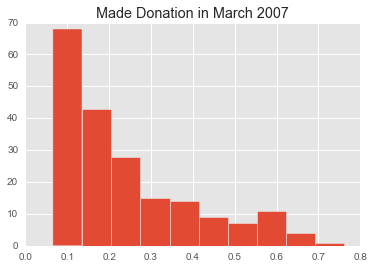

In [215]:
to_submit.hist()